In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

array([[<AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'age_cat2'}>,
        <AxesSubplot: title={'center': 'bodycomp'}>,
        <AxesSubplot: title={'center': 'smok_habits'}>],
       [<AxesSubplot: title={'center': 'packyrs_10'}>,
        <AxesSubplot: title={'center': 'diabetes'}>,
        <AxesSubplot: title={'center': 'statin'}>,
        <AxesSubplot: title={'center': 'ARB_ACE_all'}>],
       [<AxesSubplot: title={'center': 'sign_CACS'}>,
        <AxesSubplot: title={'center': 'cor_stenosis'}>,
        <AxesSubplot: title={'center': 'gold'}>,
        <AxesSubplot: title={'center': 'copd_exacerb_cat'}>],
       [<AxesSubplot: title={'center': 'resp_failure'}>,
        <AxesSubplot: title={'center': 'eosinophilic_COPD'}>,
        <AxesSubplot: title={'center': 'wholelung950'}>,
        <AxesSubplot: title={'center': 'crp_cat'}>]], dtype=object)

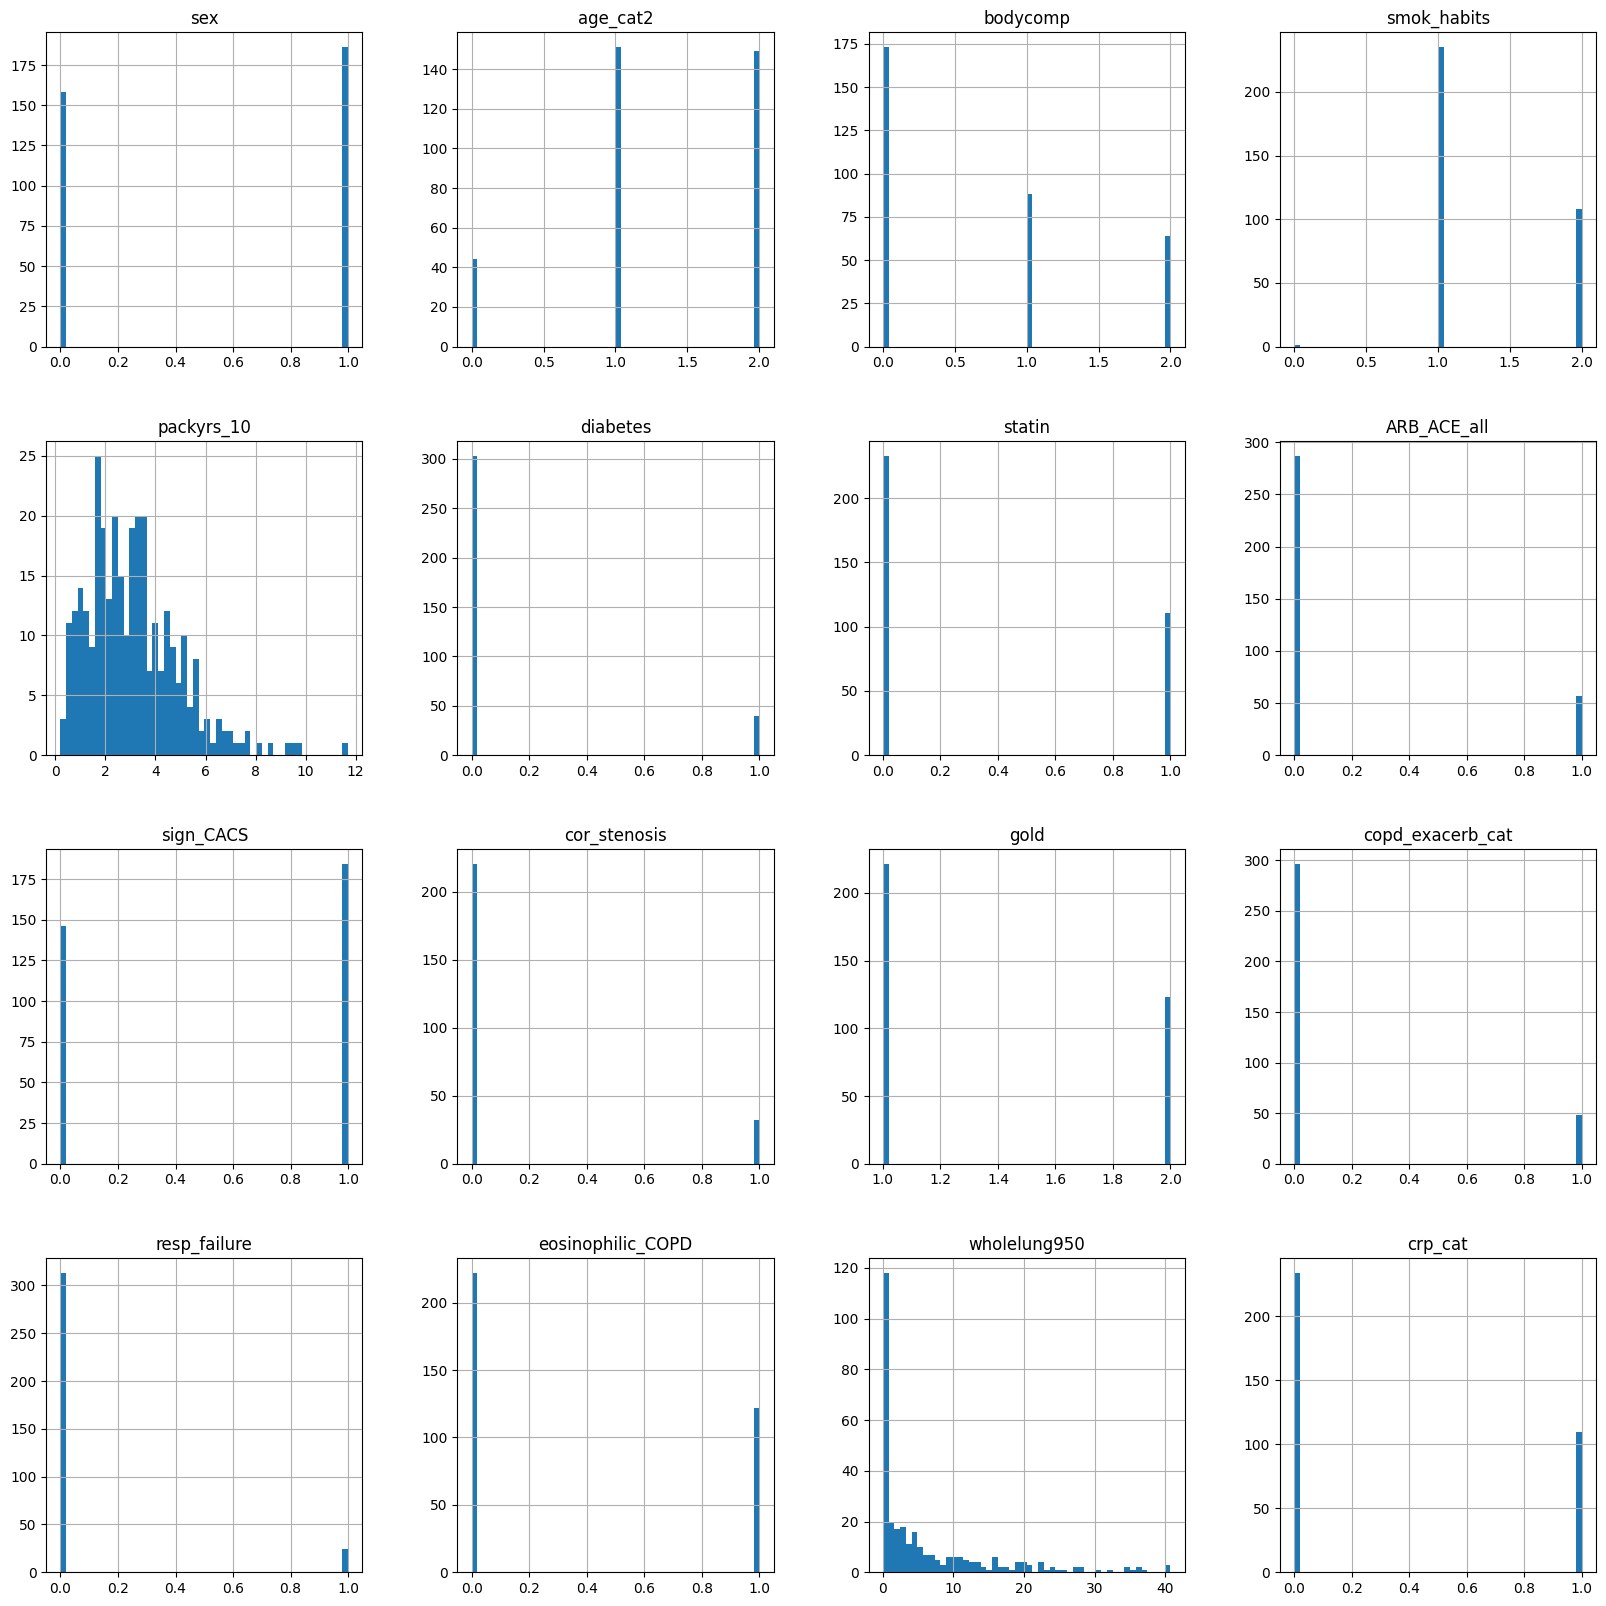

In [47]:
bergen = pd.read_excel('data/working_sheet.xlsx')

# turn label Women into 0 and Men into 1
bergen['sex'] = bergen['sex'].replace(['Women', 'Men'], [0, 1])
# turn age_cat2 into categories: 40-59.9 = 0, 60-69.9 = 1, 70+ = 2
bergen['age_cat2'] = bergen['age_cat2'].replace(['40-59.9', '60-69.9', '70+'], [0, 1, 2])
# turn bodycomp into categories: normal = 0, cachetic = 1, obese = 2
bergen['bodycomp'] = bergen['bodycomp'].replace(['normal', 'cachectic', 'obese'], [0, 1, 2])
# turn smok_habits into categories: never = 0, ex = 1, daily = 2
bergen['smok_habits'] = bergen['smok_habits'].replace(['never', 'ex', 'daily'], [0, 1, 2])
# turn gold into categories: I/II = 0, III/IV = 1
bergen['gold'] = bergen['gold'].replace(['I/II', 'III/IV'], [1, 2])
# turn COPD_control into categories: control = 0, copd = 1
bergen['COPD_control'] = bergen['COPD_control'].replace(['control', 'copd'], [0, 1])


# turn all values that say 'no' to 0
bergen = bergen.replace('no', 0)
# turn all values that say 'yes' to 1
bergen = bergen.replace('yes', 1)
# set resp_failure in all rows where COPD_control is 0 to 0
bergen.loc[bergen['COPD_control'] == 0, 'resp_failure'] = 0
# set gold in all rows where COPD_control is 0 to 0
bergen.loc[bergen['COPD_control'] == 0, 'gold'] = 0
# turn packyrs_10 and wholelung950 into a float with 2 decimal points
bergen['packyrs_10'] = bergen['packyrs_10'].astype(float).round(2)
bergen['wholelung950'] = bergen['wholelung950'].astype(float).round(2)

# drop all controls
bergen = bergen[bergen.COPD_control != 0]
# drop COPD control column
bergen = bergen.drop(['COPD_control'], axis=1)
# drop all rows with NaN values in copd_exacerb_cat
bergen = bergen.dropna(subset=['copd_exacerb_cat'])

# show histogram
bergen.hist(bins=50, figsize=(20, 20))

# Missing value

<AxesSubplot: >

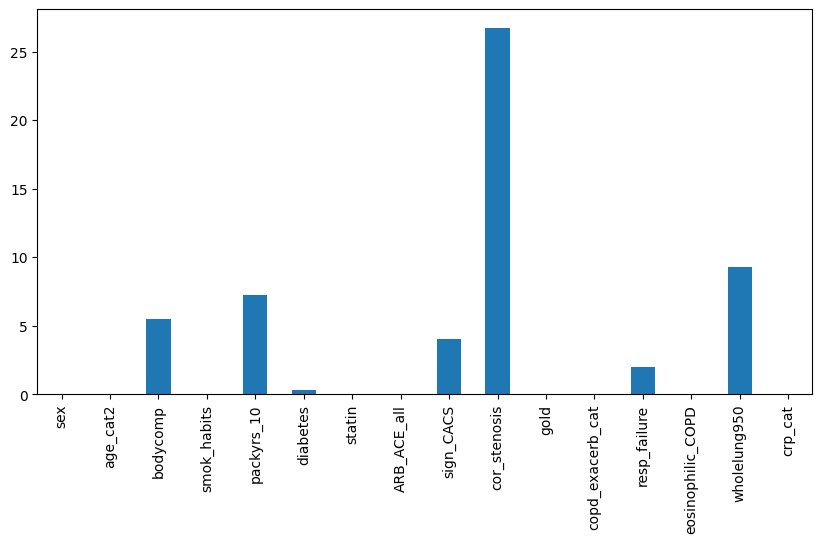

In [48]:
# display missing value percentage per variable
# create barplot
(bergen.isnull().sum()/len(bergen)*100).plot(kind='bar', figsize=(10,5))



In [52]:
# pipeline

from sklearn.base import TransformerMixin
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
# logistic regression classifier
from sklearn.linear_model import LogisticRegression
# import PCA
from sklearn.decomposition import PCA


bergen = bergen[['sex','age_cat2', 'bodycomp', 'smok_habits', 'packyrs_10', 'diabetes', 'gold', 'copd_exacerb_cat']]

class CustomImputer(TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # impute all missing values using median
        X_res = X.fillna(X.median())
        return X_res
    
class FeatureSelector(TransformerMixin):
    def __init__(self, num_features=10):
        # the number of the best features to select
        self.num_features = num_features

    # TODO take different feature selection techniques depending on argument
    def fit(self, X, y):
        information_gain = mutual_info_classif(X, y)
        self.best_features = np.argsort(information_gain)[-self.num_features:]
        print("fit feature selector")
        return self

    def transform(self, X, y=None):
        # get the indices of the best features
        return X[:,self.best_features]

    def set_params(self, **kwargs):
        self.num_features = kwargs['num_features']
        return self

# get all the variables that are not the target variable
X = bergen.drop(columns=['copd_exacerb_cat'])
# get the target variable
y = bergen['copd_exacerb_cat']

print(y.value_counts())

cv_pipeline = Pipeline(steps = [
    ['imputer', SimpleImputer(strategy='median', verbose=1)],
    ['scaler', StandardScaler()],
    ['feature_selection', FeatureSelector(num_features=2)],
    ['clf', XGBClassifier()],
    
],verbose=True)

scores = cross_val_score(cv_pipeline, X, y, scoring='roc_auc', )
print(scores)

    




# xgb_pipeline = Pipeline(steps = [
#     ['imputer', CustomImputer()],
#     ['scaler', StandardScaler()],
#     ['feature_selection', FeatureSelector()],
#     # ['pca', PCA()],
#     ['rf', XGBClassifier()]
# ])


# # k_fold = KFold(n_splits=10, shuffle=True)

# # create a list of all the metrics we want to calculate
# # scoring = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'AUC': 'roc_auc'}

# xgb_param_grid = {
#     # 'feature_selection__num_features': [5, 10, 20, 30, X.shape[1]],
#     # "pca__n_components": [None,2, 3, 5],
#     'rf__n_estimators': [5, 10, 20, 50, 100, 200, 500],
#     'rf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'rf__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
# }

# xgb_grid_search = GridSearchCV(estimator=xgb_pipeline,
#                            param_grid=xgb_param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            n_jobs=-1, verbose=3, return_train_score=True)

# xgb_grid_search.fit(X, y)

# # plot train and test scores


# # print best parameters
# print(xgb_grid_search.best_params_)

# xgb_cv_score = xgb_grid_search.best_score_
# print(xgb_cv_score)

0.00    296
1.00     48
Name: copd_exacerb_cat, dtype: int64
[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
fit feature selector
[Pipeline] . (step 3 of 4) Processing feature_selection, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.0s
[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
fit feature selector
[Pipeline] . (step 3 of 4) Processing feature_selection, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.0s
[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
fit feature selector
[Pipeline] . (step 3 of 4) Processing feature_selection, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.0s
[Pipeline] ........... (

Accuracy: 0.8969072164948454


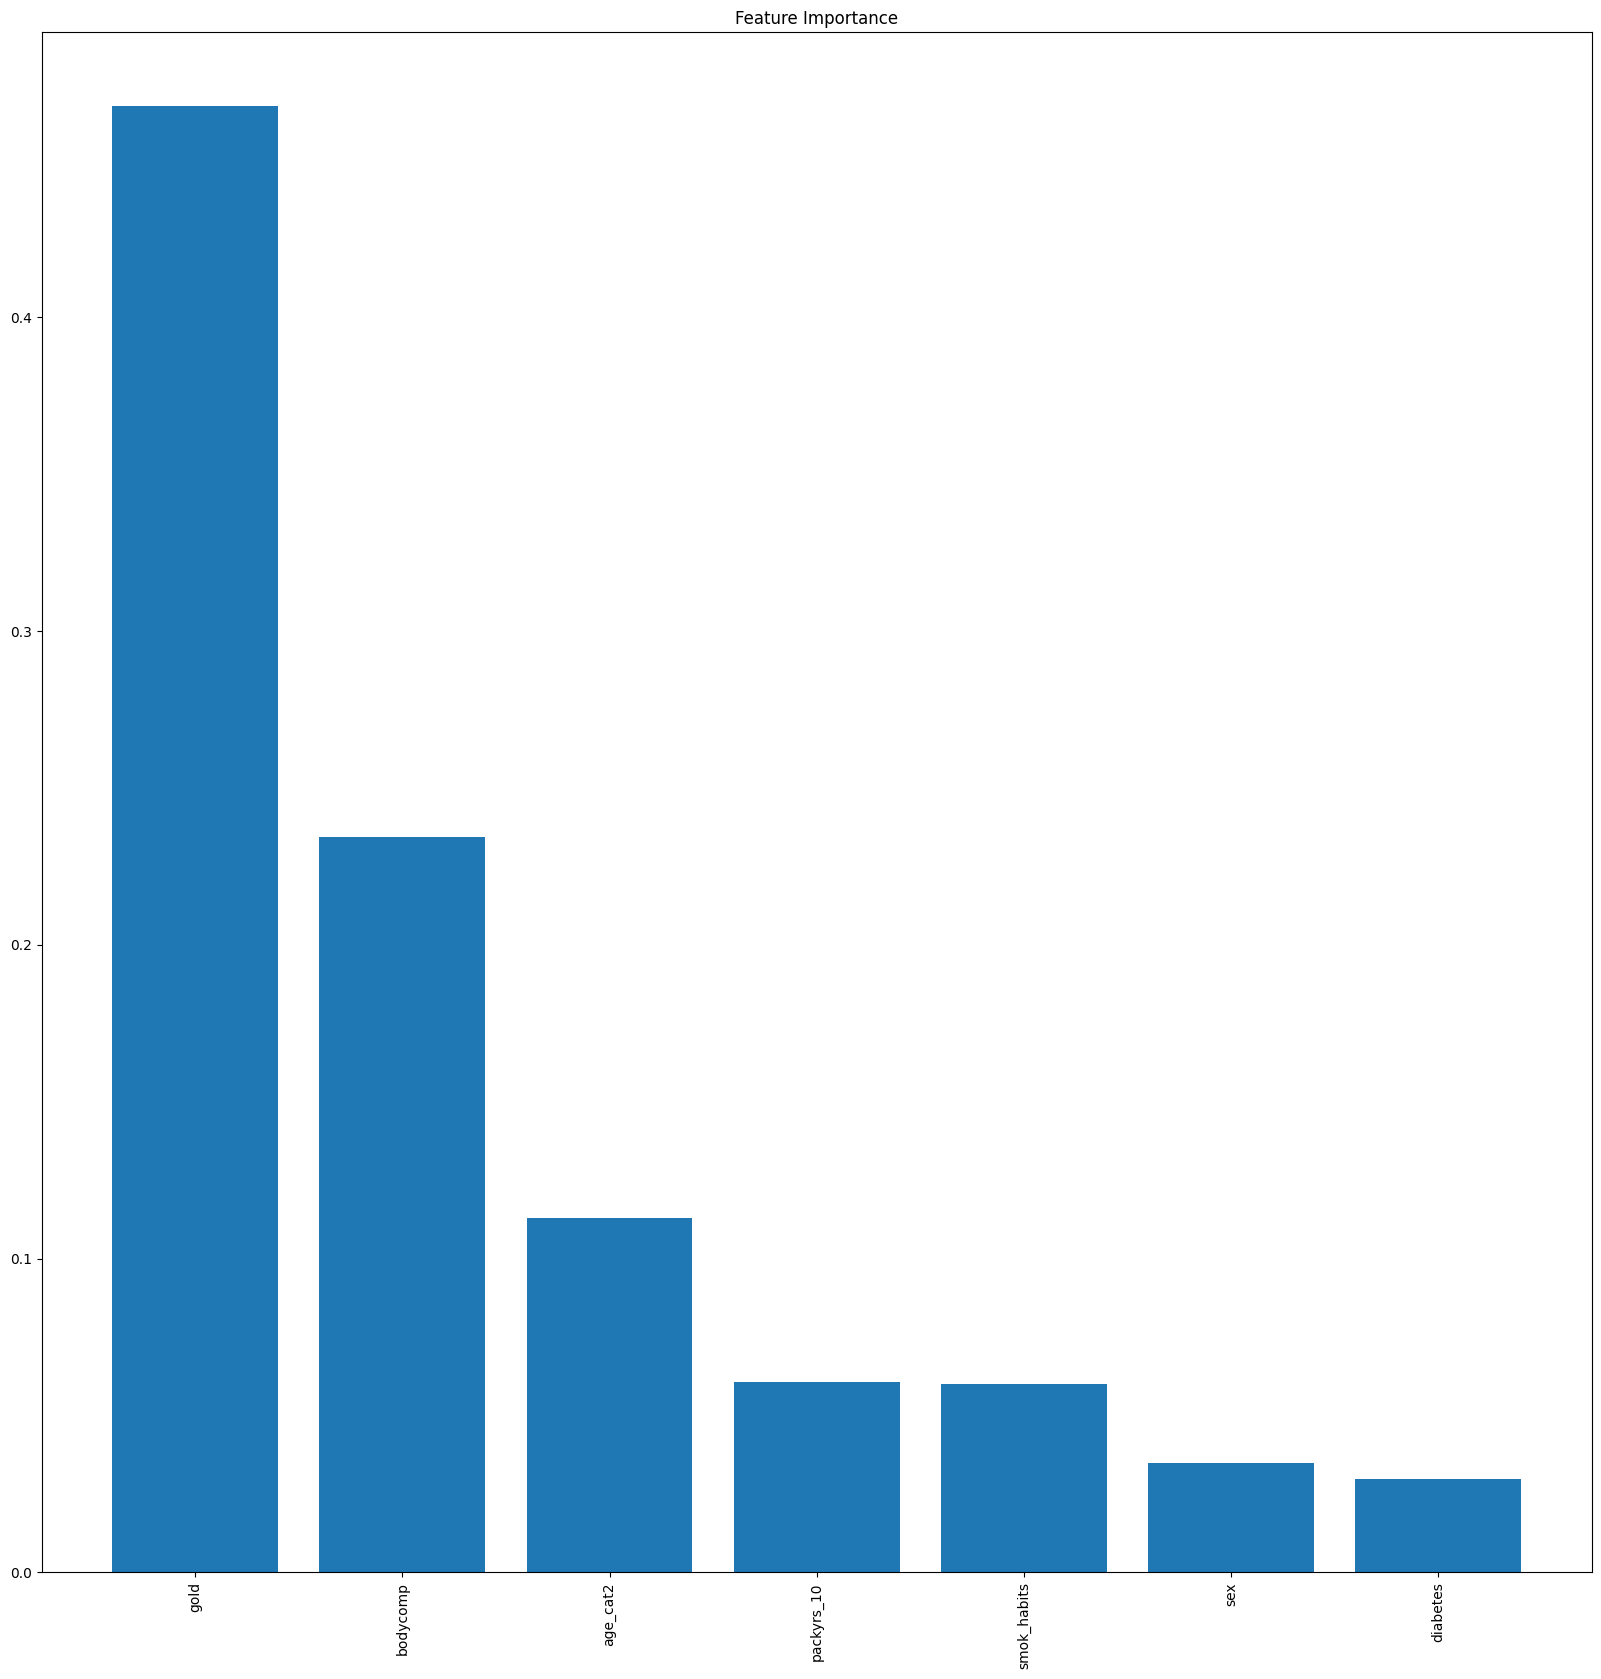

In [ ]:
########
# Classification
########
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# drop correlated variables
# bergen = bergen.drop(columns=['gold', 'COPD_control', 'resp_failure'])

# try only using variables available in harvard: sex,age_cat2, bodycomp, smok_habits, packyrs_10, diabetes,  gold, copd_exacerb_cat
bergen = bergen[['sex','age_cat2', 'bodycomp', 'smok_habits', 'packyrs_10', 'diabetes', 'gold', 'copd_exacerb_cat']]

# only take patients with COPD_control = 1

X = bergen.drop(columns=['copd_exacerb_cat'])
y = bergen['copd_exacerb_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# get variable importances
importances = clf.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# rearrange feature names so they match the sorted feature importances
names = [bergen.columns[i] for i in indices]
# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()


